In [1]:
# import internal files
import emulators
import sample
import historymatch
import plot

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10})

import importlib
import time
from scipy import stats
from scipy.stats import norm, uniform
import scipy.optimize

In [2]:
ndim = 6

In [88]:
Nx = 6
x_bound = np.array([0.1, 0.9])
xvals = np.linspace(x_bound[0], x_bound[-1], Nx)


def toy_model6D(theta_1, theta_2, theta_3, theta_4, theta_5, theta_6):
    
    x_bound = np.array([0.1, 0.9])
    Nx = 4
    xvals = np.linspace(x_bound[0], x_bound[-1], Nx)

    outputs =  []
    for x in xvals:
        output = theta_1 + theta_2*(x) + (theta_3**1)*(x**2) + theta_4*(x**3) \
               + theta_5 + theta_6
        outputs.append(output)
    for x in xvals:
        output = theta_1 + theta_2*np.sin(x) + theta_3*(x) + (theta_4)*np.cos(x) \
               + theta_5*(2*x) - theta_6*(np.cos(x))
        outputs.append(output)
    return np.array(outputs)

def toy_model3D(theta_1, theta_2, theta_3):
    
    x_bound = np.array([0.1, 1])
    Nx = 4
    xvals = np.linspace(x_bound[0], x_bound[-1], Nx)

    outputs =  []
    for x in xvals:
        output = theta_1 + theta_2*(x) + (theta_3**1)*(x**2)
        outputs.append(output)
    for x in xvals:
        output = theta_1 + theta_2*np.sin(x) + theta_3*np.cos(2*x)
        outputs.append(output)
    return np.array(outputs)

In [89]:
def model_eqn_1(theta_0, theta_1, theta_2):
    outputs =  []
    for x in xvals:
        output = theta_0 + theta_1*(x) + theta_2*(x**2)
        outputs.append(output)
        
    return outputs
    
function1 = np.vectorize(model_eqn_1)

def model_eqn_2(theta_0, theta_1, theta_2):
    outputs =  []
    for x in xvals:
        output = theta_0 - theta_1*np.sin(x) + theta_2*np.cos(x)
        outputs.append(output)
    return outputs

function2 = np.vectorize(model_eqn_2)

In [90]:
# generate observational data with some uncertainty
true_parameters_3D = [-0.1, 0.3, 0.6]
true_parameters = [-0.1, 0.3, 0.6, -0.8, 0.2, 0.15]

var_obs = 0.001 # observational uncertainty variance

error_obs_1 = np.random.normal(0, np.sqrt(var_obs), Nx)
error_obs_2 = np.random.normal(0, np.sqrt(var_obs), Nx)

obs_data_1 = model_eqn_1(*true_parameters_3D) + error_obs_1
obs_data_2 = model_eqn_1(*true_parameters_3D) + error_obs_2

print(obs_data_1)



[-0.00608641  0.04245457  0.12677785  0.28820071  0.48870717  0.64703704]


In [91]:
parameter_bounds = np.ones((ndim,2))
parameter_bounds[:,0] = -parameter_bounds[:,0]

theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_3_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_4_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_5_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)



theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1)\
                            , theta_3_vals.reshape(1,-1), theta_4_vals.reshape(1,-1), theta_5_vals.reshape(1,-1)), axis=0)

In [92]:
def design_matrix_f1(x):
    X_d = np.zeros((len(x),3))
    for i in range(3):
        X_d[:,i] = x**i
    #X_d[:,4] = 10*x**4
    #X_d[:,5] = x**5
    return X_d

def design_matrix_f2(x):
    X_d = np.zeros((len(x),6))
    X_d[:,0] = 1
    X_d[:,1] = np.sin(x)
    X_d[:,2] = np.sin(2*x)
    X_d[:,3] = np.cos(x)
    X_d[:,4] = np.cos(2*x)
    X_d[:,5] = -np.cos(x)*np.sin(x)
    return X_d

In [93]:
# Create design matrix
X1 = design_matrix_f1(xvals)
print(X1)
X2 = design_matrix_f2(xvals)

[[1.     0.1    0.01  ]
 [1.     0.26   0.0676]
 [1.     0.42   0.1764]
 [1.     0.58   0.3364]
 [1.     0.74   0.5476]
 [1.     0.9    0.81  ]]


In [94]:
def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance)
    return X_d

In [95]:
A1 = A_matrix(X1, var_obs)
b1 = obs_data_1 / np.sqrt(var_obs)

A2 = A_matrix(X2, var_obs)
b2 = obs_data_2 / np.sqrt(var_obs)

In [96]:
def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()

In [97]:

thet = solve_theta(A1,b1)

print(thet)
print(np.dot(A1,thet))
print(b1)

true_parameters = [-0.1, 0.3, 0.6, -0.8, 0.2, 0.15]

[-0.03702694  0.14395028  0.70708507]
[-0.49208383  1.52418897  4.68529342  8.99122951 14.44199725 21.03759663]
[-0.19246925  1.34253143  4.0090675   9.11370676 15.4542778  20.46110772]


In [36]:
def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))


In [37]:
cov_matrix_f1 = covariance(X1, var_obs)
cov_matrix_f2 = covariance(X2, var_obs)
theta_f1 = solve_theta(A1, b1)
theta_f2 = solve_theta(A2, b2)

true_thetas = [theta_f1, theta_f2]


H1 = H_matrix(A1)
H2 = H_matrix(A2)

ndim = 6

theta_no_var = solve_theta(X1, z_1)
print(theta_f1)

[ -0.18689661   3.09576892 -19.82100486  54.65280093  -6.16254486
  26.21361493]


In [38]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color)
    #ax.plot(Ell_rot[:,0], Ell_rot[:,1])

In [39]:
def plot_ellipses(fig, parameter_bounds, true_parameters, H, theta_best, theta_vals, color):
    theta_names = [r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$', r'$\theta_{4}$', r'$\theta_{5}$', r'$\theta_{6}$']
    N = len(theta_best)
    for i in range(N):
        for j in range(N):
            ax = fig.axes[i + N*j]
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i == j:
                if color == 'mediumaquamarine':
                    ax_right = ax.twinx()
                    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)
                    ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 2)), fontsize=14)
                
            elif i < j:
                
                cov_matrix = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
                get_cov_ellipse(cov_matrix, [theta_best[i], theta_best[j]], 3, ax, color)
                #ax.set_ylabel(theta_names[j])
                #ax.set_xlabel(theta_names[i])
                ax.set_xlim([parameter_bounds[i,0], parameter_bounds[i,1]])
                ax.set_ylim([parameter_bounds[j,0], parameter_bounds[j,1]])
                
            else:
                ax.axis('off')

<ipython-input-39-780258f30e90>:13: RuntimeWarning: invalid value encountered in sqrt
  ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)
<ipython-input-39-780258f30e90>:13: RuntimeWarning: invalid value encountered in sqrt
  ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)


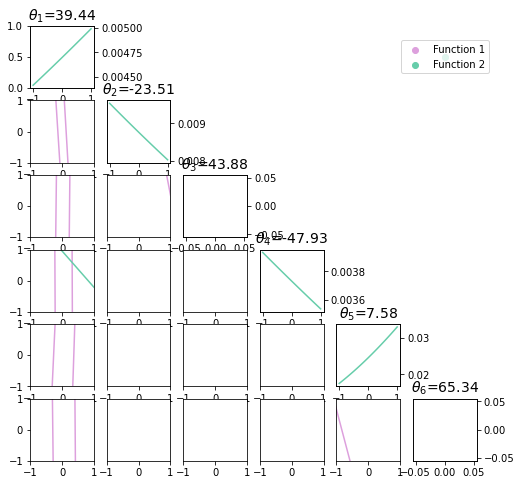

In [40]:
color_list = ['plum', 'mediumaquamarine']
N = ndim
fig, axes = plt.subplots(N,N,figsize=(8,8))

ax = fig.axes[5]
plot_ellipses(fig, parameter_bounds, true_parameters, H1, theta_f1, theta_vals, color_list[0])
plot_ellipses(fig, parameter_bounds, true_parameters, H2, theta_f2, theta_vals, color_list[1])
ax.scatter(1,1,color=color_list[0],label='Function 1')
ax.scatter(1,1,color=color_list[1],label='Function 2')
ax.legend(loc='center')

In [ ]:

z = -0.06387078

In [ ]:
print(sd1[0])
print(sd2[0])
print(mu1 - Y_3D_test)
print(mu2 - Y_3D_test)

In [ ]:
HMtest = historymatch.HistoryMatch(z,
                               3, 'GP', 'ellipsoid')

In [ ]:
imp1 = HMtest.implausibility(mu1, z, sd1, 0, var_obs)
imp2 = HMtest.implausibility(mu2, z, sd2, 0, var_obs)
print(imp1)
print(imp2)

In [ ]:
samp1 = np.concatenate((X_3D_test, imp1.reshape(-1,1)), axis=1)
samp2 = np.concatenate((X_3D_test, imp2.reshape(-1,1)), axis=1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

plot.plot_implausibility2D(samp1, parameter_bounds, [0,1], bins=20, Fig=(fig, ax1), colorbar=False, 
                            labels=None, plot_kwargs=None)
plot.plot_implausibility2D(samp2, parameter_bounds, [0,1], bins=20, Fig=(fig, ax2), colorbar=False, 
                            labels=None, plot_kwargs=None)